In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
tickers = ['^GSPC']

for ticker in tickers:
    data = yf.download(tickers=ticker, period='max', interval='60m', threads=True, progress=False)
    data = data[['Close']]

In [ ]:
# Use 'Close' prices
data = data[['Close']]

In [ ]:
# Step 2: Data Preprocessing

data = data.dropna()

scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data[['Close']])

train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
len(data)
data.head()

Price,Close
Ticker,^GSPC
Datetime,
2022-12-08 09:30:00,0.085721
2022-12-08 10:30:00,0.081066
2022-12-08 11:30:00,0.079901
2022-12-08 12:30:00,0.083636
2022-12-08 13:30:00,0.078105


In [ ]:
lags = 5
sequence_length = lags
batch_size = 1

# Create sequences for LSTM
generator = TimeseriesGenerator(train['Close'].values, train['Close'].values,
                                length=sequence_length, batch_size=batch_size)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='tanh', input_shape=(sequence_length, 1), recurrent_dropout=0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Reshape data for LSTM
train_data = train['Close'].values.reshape(-1, 1)
model.fit(generator, epochs=10, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  30/2793 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0820

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2793/2793 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0051
Epoch 2/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 1.4324e-04
Epoch 3/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.4156e-04
Epoch 4/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.1487e-04
Epoch 5/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.1948e-04
Epoch 6/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.2488e-04
Epoch 7/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.0011e-04
Epoch 8/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.3367e-05
Epoch 9/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 9.7355e-05
Epoch 10/10
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.0330e-05


In [ ]:
test_generator = TimeseriesGenerator(data['Close'].values, data['Close'].values,
                                     length=sequence_length, batch_size=batch_size)

# Predict with LSTM
lstm_pred = model.predict(test_generator)[-len(test):]
lstm_pred = scaler.inverse_transform(lstm_pred)

# Calculate residuals
test_actual = scaler.inverse_transform(test['Close'].values.reshape(-1, 1))
residuals = test_actual - lstm_pred


3493/3493 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step


In [ ]:
rmse = np.sqrt(mean_squared_error(test_actual, lstm_pred))
mae = mean_absolute_error(test_actual, lstm_pred)

print(f'LSTM RMSE: {rmse}')
print(f'LSTM MAE: {mae}')

LSTM RMSE: 50.35028806869305
LSTM MAE: 45.04096540178573


In [ ]:
residuals = residuals.ravel()
best_model = auto_arima(residuals,
                        seasonal=False,
                        stepwise=True,
                        suppress_warnings=True,
                        error_action="ignore")
best_order = best_model.order

# Train ARIMA with the best order
arima_model = ARIMA(residuals, order=best_order)
arima_fit = arima_model.fit()

# Predict residuals with ARIMA
arima_pred_residuals = arima_fit.forecast(steps=len(test))
arima_pred_residuals = arima_pred_residuals.reshape(-1, 1)

In [ ]:
final_pred = lstm_pred + arima_pred_residuals

41.630533134321134
33.60022515255004


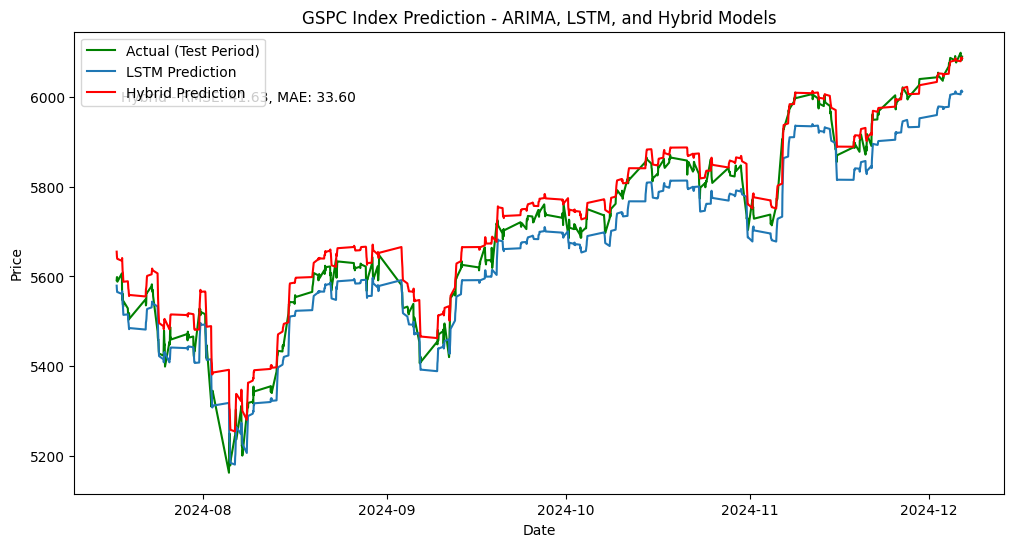

In [ ]:
rmse_hybrid = np.sqrt(mean_squared_error(test_actual, final_pred))
mae_hybrid = mean_absolute_error(test_actual, final_pred)
print(rmse_hybrid)
print(mae_hybrid)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test_actual, label='Actual (Test Period)', color='green')
plt.plot(test.index, lstm_pred, label='LSTM Prediction')
plt.plot(test.index, final_pred, label='Hybrid Prediction', color="Red")

# Add title and labels
plt.title('GSPC Index Prediction - ARIMA, LSTM, and Hybrid Models')
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()
plt.text(0.05, 0.85, f'Hybrid - RMSE: {rmse_hybrid:.2f}, MAE: {mae_hybrid:.2f}',
         transform=plt.gca().transAxes, fontsize=10)
plt.show()

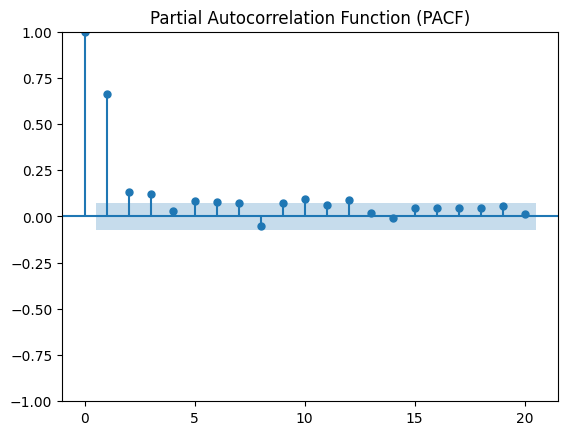

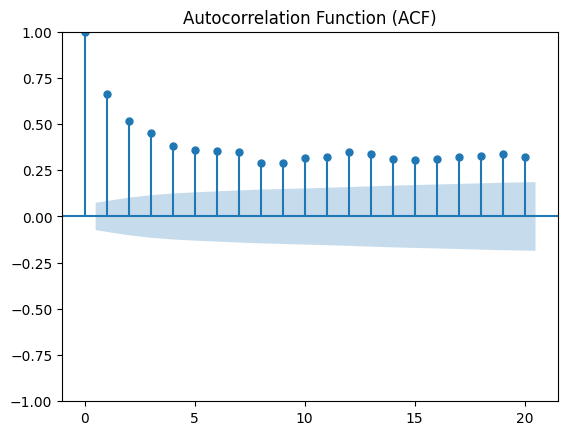

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Assuming 'residuals' are the residuals from your LSTM model
plot_pacf(residuals, lags=20)  # Adjust lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

plot_acf(residuals, lags=20)  # Adjust lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()